In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x),
                           data_transforms[x])
    for x in ['train', 'val']}
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x],
                                   batch_size=4, shuffle=True, num_workers=4)
    for x in ['train', 'val']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device('cuda')

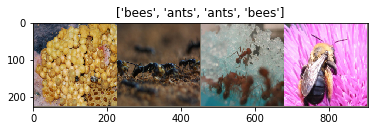

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                        
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model


In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [17]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [18]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


Epoch 0/24
----------
train Loss: 0.5892 Acc: 0.7336
val Loss: 0.4001 Acc: 0.8235

Epoch 1/24
----------
train Loss: 0.4770 Acc: 0.7910
val Loss: 0.3788 Acc: 0.8431

Epoch 2/24
----------
train Loss: 0.6731 Acc: 0.7295
val Loss: 0.2405 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.5681 Acc: 0.7951
val Loss: 0.3461 Acc: 0.8627

Epoch 4/24
----------
train Loss: 0.5768 Acc: 0.7746
val Loss: 0.2295 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.4726 Acc: 0.7910
val Loss: 0.2125 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.4243 Acc: 0.8525
val Loss: 0.3082 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.3897 Acc: 0.8566
val Loss: 0.2228 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3059 Acc: 0.8852
val Loss: 0.2100 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.2238 Acc: 0.9098
val Loss: 0.2148 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3595 Acc: 0.8443
val Loss: 0.1894 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.1946 Acc: 0.9180
val Loss: 0.2037 Acc: 0.9281

Ep

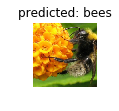

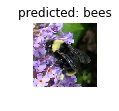

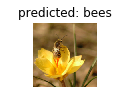

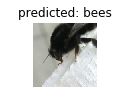

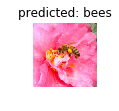

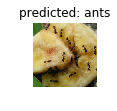

In [20]:
visualize_model(model_ft)

In [31]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [32]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                        exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6179 Acc: 0.6885
val Loss: 0.3146 Acc: 0.8366

Epoch 1/24
----------
train Loss: 0.3739 Acc: 0.8238
val Loss: 0.2031 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.4182 Acc: 0.8238
val Loss: 0.2327 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.4936 Acc: 0.7787
val Loss: 0.2989 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.4576 Acc: 0.8320
val Loss: 0.2425 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.4297 Acc: 0.8320
val Loss: 0.2607 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.4948 Acc: 0.8074
val Loss: 0.4020 Acc: 0.8497

Epoch 7/24
----------
train Loss: 0.4229 Acc: 0.7992
val Loss: 0.2176 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3185 Acc: 0.8689
val Loss: 0.2399 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3908 Acc: 0.8361
val Loss: 0.2116 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3672 Acc: 0.8402
val Loss: 0.2052 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.4183 Acc: 0.8238
val Loss: 0.2125 Acc: 0.9412

Ep